In [51]:
import numpy as np
import scqubits as scq
import matplotlib.pyplot as plt
from fluxonium_tunable_coupler import *
scq.settings.PROGRESSBAR_DISABLED = True
def FTC_system(
    E_Ja, E_Jb, 
    E_Ca, E_Cb, 
    E_La, E_Lb,
    E_C, ECm, E_L1, E_L2, E_J,
    flux_a, flux_b, flux_c, 
    **kwargs
):
    FTC_grounded = FluxoniumTunableCouplerGrounded(
        EJa=E_Ja, EJb=E_Jb, EC_twoqubit=np.inf,
        ECq1=E_Ca, ECq2=E_Cb, ELa=E_La, ELb=E_Lb,
        flux_a=flux_a, flux_b=flux_b, flux_c=flux_c,
        fluxonium_cutoff=130, fluxonium_truncated_dim=4,
        ECc=E_C, ECm=ECm, EL1=E_L1, EL2=E_L2, EJC=E_J,
        fluxonium_minus_truncated_dim=6, h_o_truncated_dim=3
    )

    return FTC_grounded


In [154]:
para_exp = {
    'E_Ja': 5.2,
    'E_Jb': 5.5,
    'E_Ca': 1.5,
    'E_Cb': 1.5,
    'E_J': 3,
    'E_C': 40,
    'ECm': 50,
    'E_L2': 2,
    'E_L1': 2,
    'E_La': 0.21,
    'E_Lb': 0.21,
}

# para_exp = {
#     'E_Ja': 4.6,
#     'E_Jb': 5.5,
#     'E_Ca': 0.9,
#     'E_Cb': 0.9,
#     'E_J': 3,
#     'E_C': 16.686114352392064,
#     'ECm': 50,
#     'E_L2': 2,
#     'E_L1': 2,
#     'E_La': 0.21,
#     'E_Lb': 0.21,
# }



In [155]:
from functions import*
FTC_grounded = FTC_system(
    **para_exp,
    flux_a = 0.5,
    flux_b = 0.5,
    flux_c = 0.2,
)


In [156]:
fa = FTC_grounded.fluxonium_a()
fb = FTC_grounded.fluxonium_b()
fa.eigenvals() - fa.eigenvals()[0]

array([0.      , 0.192296, 5.537577, 7.000897, 7.812429, 7.984663])

In [157]:

fb.eigenvals() - fb.eigenvals()[0]

array([0.      , 0.171949, 5.761366, 7.157286, 7.849219, 8.007703])

In [202]:
from joblib import Parallel, delayed
from scipy.optimize import minimize

# Define the objective function to minimize the sum of flux_sa and flux_sb
def objective_function(fluxes, flux_c):
    flux_sa, flux_sb = fluxes
    FTC_grounded = FTC_system(
        **para_exp,
        flux_a=0.5 + flux_sa,
        flux_b=0.5 + flux_sb,
        flux_c=flux_c,
    )
    hs = FTC_grounded.generate_coupled_system_sweetspot()
    H0 = (hs.bare_hamiltonian() ).full()
    V = hs.interaction_hamiltonian().full()
    H0, V = shuffle_matrices(H0, V)
    swt_result = swt_subspace(H0, V, [0, 1, 2, 3])

    # Sum the relevant submatrices
    sum_matrix = sum(swt_result[1][i][0:6, 0:6] for i in range(4))

    # Calculate specific matrix elements using np.linalg.norm
    element_sum = (
        np.abs(sum_matrix[0, 1]) +
        np.abs(sum_matrix[0, 2]) +
        np.abs(sum_matrix[1, 3]) +
        np.abs(sum_matrix[2, 3])
    )
    return element_sum
# Define the objective function to minimize the sum of flux_sa and flux_sb

def H_eff(ftc):
    hs = ftc.generate_coupled_system_sweetspot()
    H0 = (hs.bare_hamiltonian() ).full()
    V = hs.interaction_hamiltonian().full()
    H0, V = shuffle_matrices(H0, V)
    swt_result = swt_subspace(H0, V, [0, 1, 2, 3])

    # Sum the relevant submatrices
    sum_matrix = sum(swt_result[1][i][0:6, 0:6] for i in range(4))
    return sum_matrix, H0[0:6, 0:6]

def derivative_matrix(ftc):
    dphi = 1e-6
    flux_a, flux_b, flux_c = ftc.flux_a, ftc.flux_b, ftc.flux_c
    eigenvals = ftc.eigenvals()[1:4] - ftc.eigenvals()[0]  # Store only the second, third, and fourth eigenvalues

    def compute_derivative(flux_a_shift=0, flux_b_shift=0, flux_c_shift=0):
        ftcp = FTC_system(
            **para_exp,
            flux_a=flux_a + flux_a_shift,
            flux_b=flux_b + flux_b_shift,
            flux_c=flux_c + flux_c_shift,
        )
        eigenvals_p = ftcp.eigenvals()[1:4] - ftcp.eigenvals()[0]  # Store only the second, third, and fourth eigenvalues
        return (eigenvals_p - eigenvals) / dphi

    der1 = compute_derivative(flux_a_shift=dphi)
    der2 = compute_derivative(flux_b_shift=dphi)
    der3 = compute_derivative(flux_c_shift=dphi)

    # Print the derivatives in matrix form with labels
    derivative_matrix = np.array([der1, der2, der3]).T

    return derivative_matrix

def compute_eigenvals_for_flux_c(flux_c):
    FTC_grounded = FTC_system(
        **para_exp,
        flux_a=0.5,
        flux_b=0.5,
        flux_c=flux_c,
    )
    flux_sa, flux_sb = FTC_grounded.find_flux_shift()
    initial_guess = [flux_sa, flux_sb]
    bounds = [(flux_sa - 0.01, flux_sa + 0.01), (flux_sb - 0.01, flux_sb + 0.01)]

    result = minimize(objective_function, initial_guess, args=(flux_c,), method='Nelder-Mead', bounds=bounds, options={'disp': True})

    optimized_flux_sa, optimized_flux_sb = result.x
    FTC_grounded = FTC_system(
        **para_exp,
        flux_a=0.5 + optimized_flux_sa, 
        flux_b=0.5 + optimized_flux_sb,
        flux_c=flux_c,
    )
    eigenvals = FTC_grounded.eigenvals()
    eigenvals = eigenvals[:4] - eigenvals[0]  # Ensure compatible shapes

    FTC_grounded = FTC_system(
        **para_exp,
        flux_a=0.5 + optimized_flux_sa,
        flux_b=0.5 + optimized_flux_sb,
        flux_c=flux_c,
    )
    # Sum the relevant submatrices
    sum_matrix, H0 = H_eff(FTC_grounded)
    der_mat = derivative_matrix(FTC_grounded)
    return eigenvals, H0[0:6, 0:6], sum_matrix, der_mat



In [203]:

# Generate flux_c values
flux_c_values = np.linspace(0.23, 0.28, 12)

# Use joblib to parallelize the computation
result = Parallel(n_jobs=-1)(delayed(compute_eigenvals_for_flux_c)(flux_c) for flux_c in flux_c_values)

In [217]:
der_matrices[11]

array([[-0.002697,  0.005825, -0.005566],
       [-0.004599,  0.00386 ,  0.002311],
       [-0.001341,  0.002105, -0.003165]])

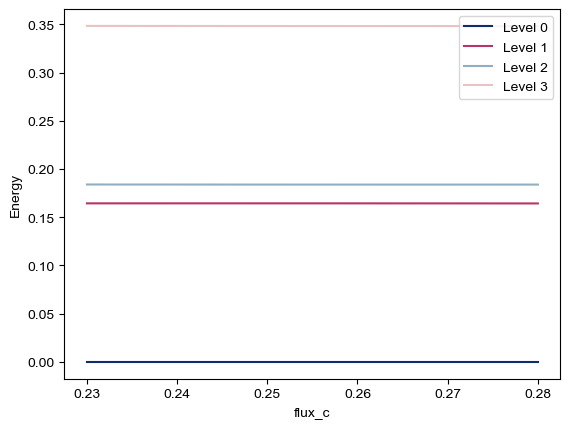

In [226]:
# Separate the result into evals_array and H_eff_array
evals_array = np.array([res[0] for res in result])
H_eff_array = np.array([res[2] for res in result])
H0_array = np.array([res[1] for res in result])
der_matrices = np.array([res[3] for res in result])
# Make diagonal elements of H_eff to be 0 and keep others
# for H_eff in H_eff_array:
#     H_eff[np.diag_indices_from(H_eff)] = 0

# Diagonalize each H_eff and plot the corresponding lowest 4 levels
eigenvalues = np.array([np.linalg.eigvalsh(H_eff + H0)[:4] for H_eff, H0 in zip(H_eff_array, H0_array)])

# Subtract the first element from each eigenvalues array
for i in range(eigenvalues.shape[0]):
    eigenvalues[i] -= eigenvalues[i, 0]
# Plot the lowest 4 levels
for i in range(4):
    plt.plot(flux_c_values, eigenvalues[:, i], label=f'Level {i}')
plt.xlabel('flux_c')
plt.ylabel('Energy')
plt.legend()
plt.show()

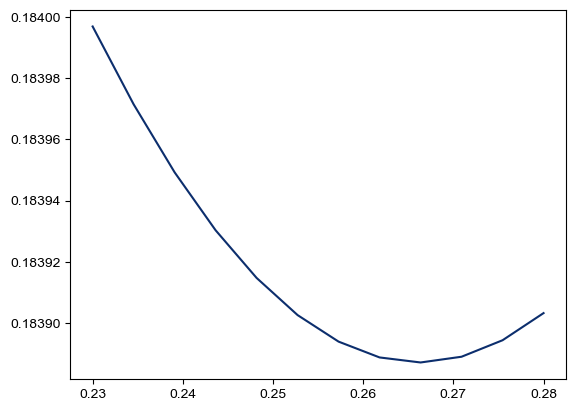

In [227]:
plt.plot(flux_c_values, eigenvalues[:, 2], label=f'Level {1}')
plt.show()

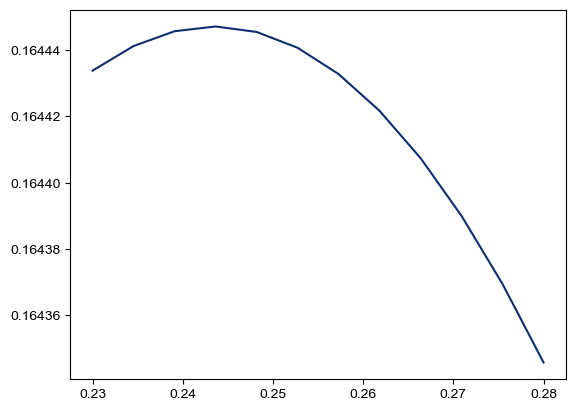

In [228]:
plt.plot(flux_c_values, eigenvalues[:, 1], label=f'Level {1}')
plt.show()

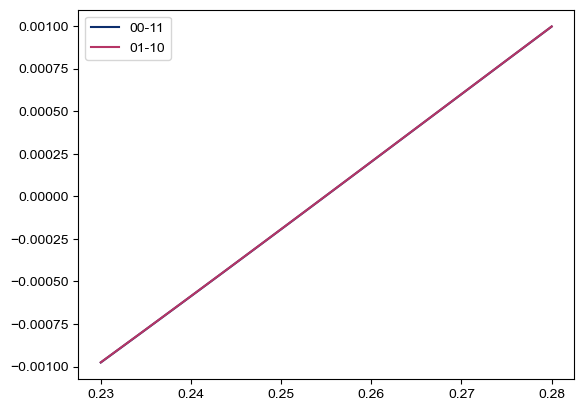

In [229]:
plt.plot(flux_c_values, np.real(H_eff_array[:,0,3]) , label='00-11')
plt.plot(flux_c_values, 
         np.real(H_eff_array[:,1,2]) , label='01-10')
plt.legend()
plt.show()


In [230]:
H_eff_array[0]

array([[-1.795752e-01+0.j, -1.442680e-06+0.j,  1.000030e-05+0.j, -9.755622e-04+0.j,  0.000000e+00+0.j,  0.000000e+00+0.j],
       [-1.442680e-06+0.j, -1.870449e-01+0.j, -9.748617e-04+0.j, -7.069940e-05+0.j,  0.000000e+00+0.j,  0.000000e+00+0.j],
       [ 1.000030e-05+0.j, -9.748617e-04+0.j, -1.879255e-01+0.j,  8.942848e-05+0.j,  0.000000e+00+0.j,  0.000000e+00+0.j],
       [-9.755622e-04+0.j, -7.069940e-05+0.j,  8.942848e-05+0.j, -1.953954e-01+0.j,  0.000000e+00+0.j,  0.000000e+00+0.j],
       [ 0.000000e+00+0.j,  0.000000e+00+0.j,  0.000000e+00+0.j,  0.000000e+00+0.j, -5.943198e-04+0.j,  1.001615e-03+0.j],
       [ 0.000000e+00+0.j,  0.000000e+00+0.j,  0.000000e+00+0.j,  0.000000e+00+0.j,  1.001615e-03+0.j, -5.943180e-04+0.j]])

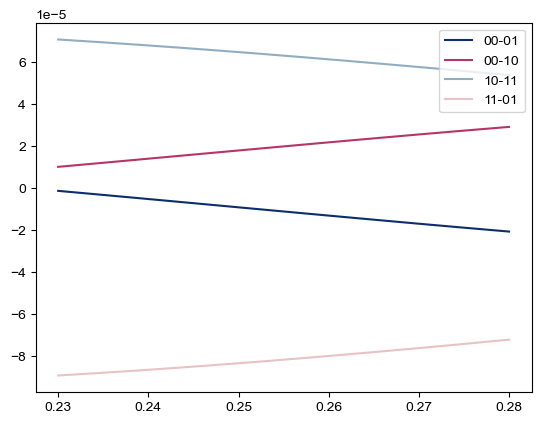

In [231]:
plt.plot(flux_c_values, np.real(H_eff_array[:,0,1]) , label='00-01')
plt.plot(flux_c_values, np.real(H_eff_array[:,0,2]) , label='00-10')
plt.plot(flux_c_values, -np.real(H_eff_array[:,1,3]) , label='10-11')
plt.plot(flux_c_values, -np.real(H_eff_array[:,2,3]) , label='11-01')
plt.legend()
plt.show()
